### Load in a model, make predictions on training data and compare given RLE mask to model's predictions

In [84]:
import keras as K
from keras.models import load_model
import numpy as np
import sys
import os
import glob
import pydicom
import pandas as pd
import cv2 #pip install opencv-python
import PIL
from PIL import Image
import gdcm #conda install -c conda-forge gdcm --> if install required, then must restart kernal...
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%pylab inline


# custom modules + paths
sys.path.append('../src/')
model_path = '../models/'
train_im_path = '../data/train/'
rle_csv = '../data/train-rle.csv'
test_im_path = '../data/test/'
from model import dice_coef, soft_dice_coef, unet_model, dice_coef_loss
from dataloader import DataGenerator

Populating the interactive namespace from numpy and matplotlib


#### Load model and custom objects

In [6]:
custom_objects = {"dice_coef":dice_coef,"dice_coef_loss":dice_coef_loss,"soft_dice_coef":soft_dice_coef}
model = load_model(model_path + 'pneumothorax.hdf5',custom_objects=custom_objects)


W0714 14:41:10.226277 140009772435264 deprecation_wrapper.py:119] From /home/keil/miniconda3/envs/mura/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 14:41:10.245192 140009772435264 deprecation_wrapper.py:119] From /home/keil/miniconda3/envs/mura/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 14:41:10.271754 140009772435264 deprecation_wrapper.py:119] From /home/keil/miniconda3/envs/mura/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 14:41:10.272365 140009772435264 deprecation_wrapper.py:119] From /home/keil/miniconda3/envs/mura/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. P

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CXR (InputLayer)                (None, None, None, 1 0                                            
__________________________________________________________________________________________________
encodeAa (Conv2D)               (None, None, None, 3 320         CXR[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         encodeAa[0][0]                   
__________________________________________________________________________________________________
encodeAb (Conv2D)               (None, None, None, 3 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [87]:
#helper functions

def mask2rle(img, width=1024, height=1024):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;
    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;
    return " ".join(rle)


def dicom2numpy(filepath):
    ds = pydicom.read_file(filepath, force=True) # read dicom image
    try:
        array = ds.pixel_array # get image array
    except:
        ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        array = ds.pixel_array # get image array
        
    return array


def dicom2jpeg(filepath, print_dicom=False):
    ds = pydicom.read_file(filepath, force=True) # read dicom image
    try:
        img = ds.pixel_array # get image array
    except:
        ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        img = ds.pixel_array # get image array
    if print_dicom == True:
        plt.imshow(img, cmap=plt.cm.bone)
        plt.show()
        return
    img_mem = Image.fromarray(img) # Creates an image memory from an object exporting the array interface
    return img_mem


def get_dcms_preds(stop=1, model=None):
    data = []
    for idx, dcm in tqdm(enumerate(os.scandir(train_im_path))):
        if idx == stop:
            return data
        array = dicom2numpy(dcm.path)
        mean = array.mean()
        std = array.std()
        
        #perfmorming standardization here on the array by sub the mean and dividing the s.d.
        standardized_array = np.divide(np.subtract(array,mean),std)
        
        expanded_array = standardized_array[np.newaxis, ..., np.newaxis]
        expanded_array_path = dcm.path
        pred_mask = model.predict(expanded_array)
        
        data.append((expanded_array_path, expanded_array, pred_mask))

#### imgs = a list of tuples of (dcm_path, (1,1024,1024,1) standardized array pairing)
- e.g. imgs[0] = first tuple 
- imgs[0][0]=path 
- imgs[0][1]=standardized_dcm 
- imgs[0][2]=predicted_mask

In [98]:
imgs = get_dcms_preds(stop=16, model=model)

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.11241.1517875231.913108.dcm


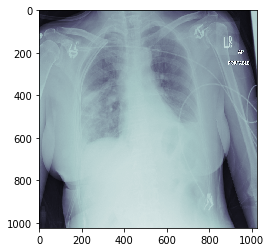

min value:0.0
max value:0.0


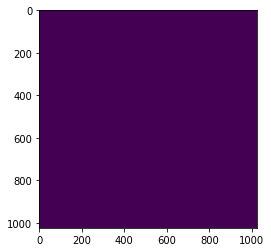

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.13403.1517875245.148715.dcm


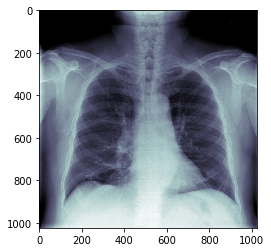

min value:0.0
max value:0.0


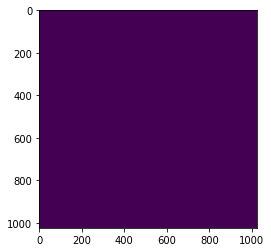

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.3705.1517875179.81759.dcm


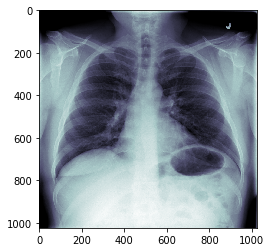

min value:0.0
max value:0.0


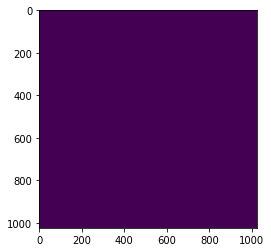

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.1622.1517875168.630031.dcm


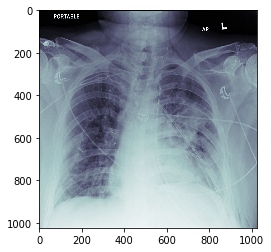

min value:0.0
max value:0.0


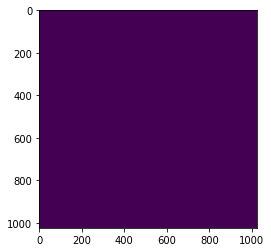

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.11669.1517875234.229971.dcm


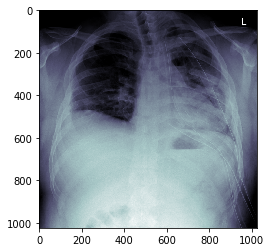

min value:0.0
max value:0.0


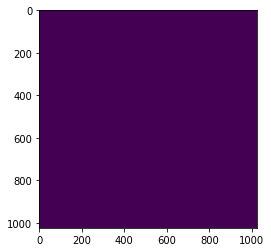

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.3202.1517875176.565353.dcm


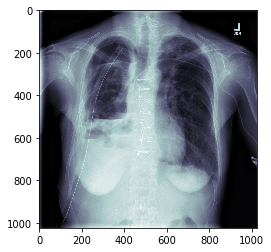

min value:0.0
max value:0.0


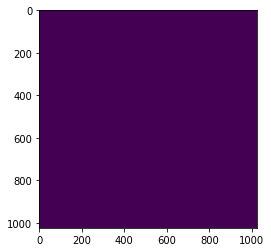

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.14391.1517875251.878297.dcm


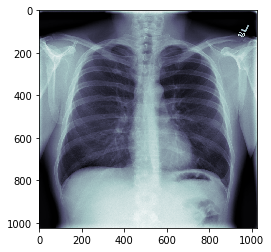

min value:0.0
max value:0.0


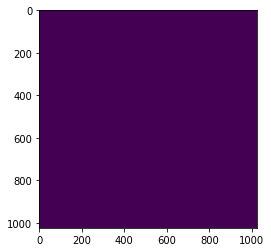

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.11651.1517875234.126644.dcm


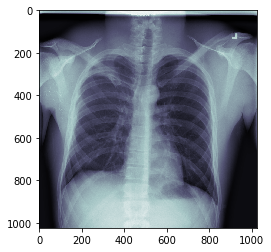

min value:0.0
max value:0.0


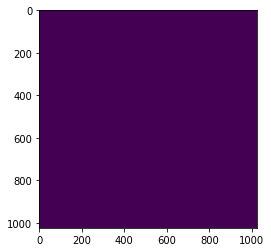

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.12028.1517875236.988922.dcm


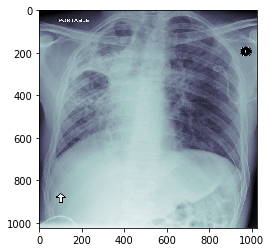

min value:0.0
max value:0.0


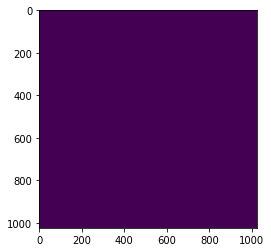

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.32687.1517875161.809750.dcm


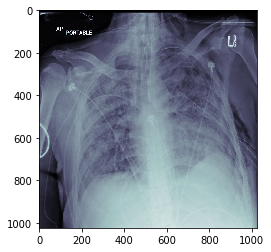

min value:0.0
max value:0.0


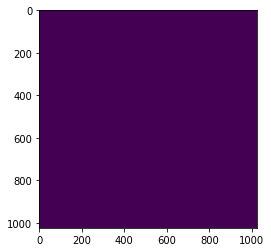

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.2057.1517875170.942743.dcm


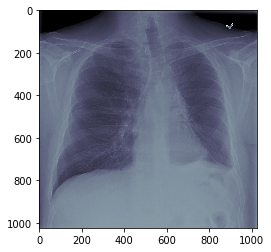

min value:0.0
max value:0.0


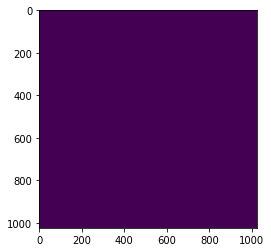

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.12543.1517875239.640481.dcm


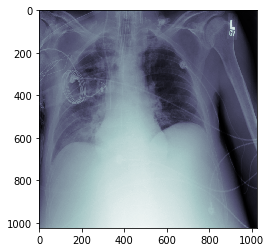

min value:0.0
max value:0.0


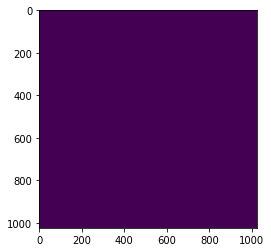

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.5032.1517875186.53508.dcm


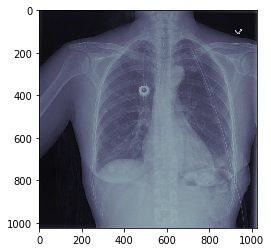

min value:0.0
max value:0.0


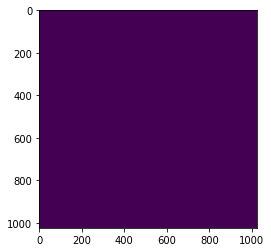

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.2280.1517875171.916982.dcm


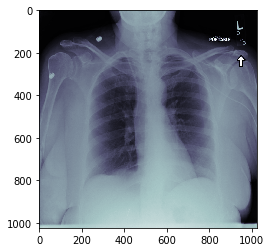

min value:0.0
max value:0.0


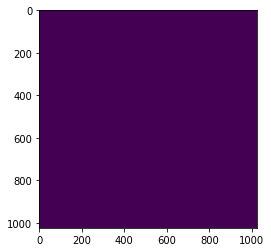

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.32469.1517875160.766227.dcm


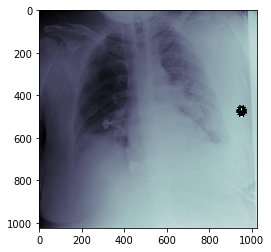

min value:0.0
max value:0.0


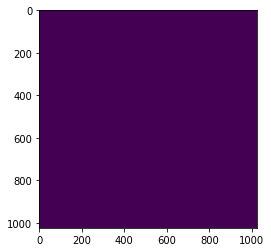

path: ../data/train/1.2.276.0.7230010.3.1.4.8323329.4202.1517875181.695624.dcm


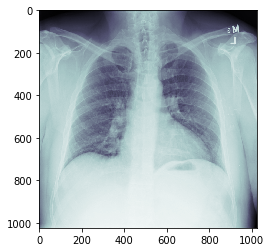

min value:0.0
max value:0.0


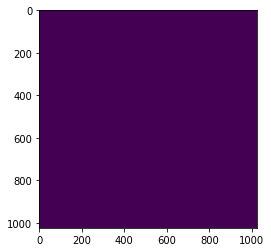

In [111]:
for idx, img in enumerate(imgs): 
    print('path: ' + str(imgs[idx][0]))
    x = dicom2jpeg(imgs[idx][0],print_dicom=True)
    print('min value:' + str(imgs[idx][2][0, :, :, 0].min()))
    print('max value:' + str(imgs[idx][2][0, :, :, 0].max()))
    plt.imshow(imgs[idx][2][0, :, :, 0])
    plt.show()